In [1]:
import os 
os.chdir("../")

In [10]:

import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

import torch
from torch import nn
from torch.nn import functional as F

from cids.data import SCVICCIDSDataset, SCVICCIDSDatasetBinary, SCVIC_CIDS_CLASSES
from cids.models.nn import MLP, Autoencoder
from cids.util.metrics import auc_score
from cids.util import misc_funcs as misc

In [3]:
idxs = np.loadtxt(os.path.join(misc.data(), "scvic/train_indices.txt"), dtype=int)
dataset = SCVICCIDSDataset(misc.data_raw(scvic=True), subset=idxs, network_data=True, host_data=True,
                                    host_embeddings=False)


In [7]:
train_idxs, val_idxs = next(StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42).split(np.zeros(len(dataset)), [d[-1] for d in dataset]))
malicious_idxs = []
benign_idxs = []
for train_idx in train_idxs:
    if dataset[train_idx][-1] != 0:
        malicious_idxs.append(train_idx)
    else:
        benign_idxs.append(train_idx)

train_idxs = np.asarray(benign_idxs)
print(train_idxs)
val_idxs = np.append(val_idxs, malicious_idxs)

train_dataset = SCVICCIDSDatasetBinary(data=dataset.data, subset=train_idxs, network_data=True, host_data=True,
                                    host_embeddings=False)
val_dataset = SCVICCIDSDatasetBinary(data=dataset.data, subset=val_idxs, network_data=True, host_data=True,
                                    host_embeddings=False)
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=8, num_workers=1, shuffle=True)
eval_dl = torch.utils.data.DataLoader(val_dataset, batch_size=8, num_workers=1, shuffle=False)

[376383 396532   5595 ... 573952 674069 126713]


In [8]:
device = "cuda:2"
model_config = {"input_dim": 356, "output_dim": 15, "hidden_dims": [128]}
encoder = MLP(**model_config)
model_config["input_dim"], model_config["output_dim"] = model_config["output_dim"], model_config["input_dim"]
decoder = MLP(**model_config)
decoder = nn.Sequential(decoder, nn.Sigmoid())

model = Autoencoder(encoder=encoder, decoder=decoder)
model.to(device)

Autoencoder(
  (encoder): MLP(
    (input_layer): Linear(in_features=356, out_features=128, bias=True)
    (hidden_layers): ModuleList()
    (output_layer): Linear(in_features=128, out_features=15, bias=True)
    (dropout): Identity()
  )
  (decoder): Sequential(
    (0): MLP(
      (input_layer): Linear(in_features=15, out_features=128, bias=True)
      (hidden_layers): ModuleList()
      (output_layer): Linear(in_features=128, out_features=356, bias=True)
      (dropout): Identity()
    )
    (1): Sigmoid()
  )
)

In [26]:
counts_benign = 0
counts_mal = 0

for train_data in train_dl:
    lbl = train_data[-1]
    counts_benign += lbl.shape[0] - lbl.sum()
    counts_mal += lbl.sum()

print(counts_benign, counts_mal)

tensor(294750) tensor(0)


In [24]:
counts_benign = 0
counts_mal = 0
with torch.no_grad():
    model.eval()
    eval_loss = 0
    eval_steps = 0
    scores = []
    labels = []
    for eval_data in eval_dl:
        eval_inp = torch.concat([torch.flatten(eval_data[i], start_dim=1) for i in range(len(eval_data) - 1)], dim=1)
        eval_inp = eval_inp.to(device)
        eval_out = model(eval_inp)
        eval_labels = eval_data[-1].to(device)
        counts_benign += eval_labels.shape[0] - eval_labels.sum()
        counts_mal += eval_labels.sum()
        loss_expanded = F.mse_loss(eval_inp, eval_out, reduction="none")            
        eval_loss += (loss_expanded.mean(dim=1) * (1 - eval_labels)).mean().item()
        
        scores.extend(torch.mean(loss_expanded, dim=1).detach().cpu().numpy())
        labels.extend(eval_labels.detach().cpu().numpy())

        eval_steps += 1
    
    eval_loss /= eval_steps
    

In [25]:
eval_score = auc_score(labels, scores)
print(counts_benign, counts_mal)
print(len(labels), len(scores))
print(eval_score)

tensor(73687, device='cuda:2') tensor(368438, device='cuda:2')
442125 442125
0.4040063032856825


In [20]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

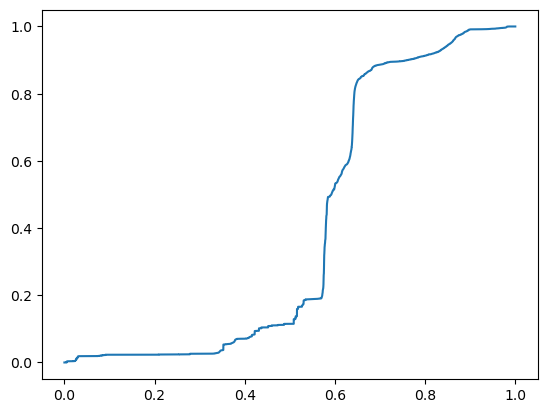

In [21]:
fpr, tpr, _ = roc_curve(labels, scores)
plt.plot(fpr, tpr)
plt.show()